In [1]:
from deepscore import DeepScore
from preprocessing import *
import scanpy as sc
import episcanpy as epi
import anndata as ad
from tensorflow import keras
import os, gc

%load_ext rpy2.ipython
%load_ext tensorboard 
os.chdir("/home/pab/projects/ESPACE/ESPACE_multiome")
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')

In [2]:
%%R

library(Seurat)
library(Signac)
library(glue)
library(GenomicRanges)
set.seed(1234)
setwd("~/projects/ESPACE/ESPACE_multiome")
source("~/projects/utils/multiple_scataq_analysis.R")

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.gri

In [3]:
%%R

get_peaks_from_object <- function(folder_file, assay="peaks") {
    
    folder = folder_file[1]
    object_file = folder_file[2]
  
    assign('seu', get(load(glue("{folder}/{object_file}"))))
    DefaultAssay(seu) <- assay
    return(granges(seu))
}

sample_folders_files <- list(list("sample5-tween", "espace.RData"),
                          list("sample5", "espace.RData"),
                          list("/home/pab/projects/ESPACE/BERLIN/atac/ESPACE-HCVH_OD-D4_C_07_B_D2_MB_1", "seu_filtered.RData"))
                
# Common set of peaks
peaks <- lapply(sample_folders_files, get_peaks_from_object, assay="peaks")
combpeaks <- reduce(c(peaks[[1]], peaks[[2]], peaks[[3]]))
combpeaks <- combpeaks[width(combpeaks) < 10000 & width(combpeaks) > 20]
length(combpeaks)

[1] 142873


In [ ]:
%%R

library(future)
plan("multiprocess", workers = 6)
options(future.globals.maxSize = 10000 * 1024^2)

lapply(sample_folders_files, build_combined, combpeaks, drop_predictions = T)

In [ ]:
!pwd
!Rscript ../../utils/seurat2anndata.R sample5-tween/espace_ds_combpeaks.RData peaks
!Rscript ../../utils/seurat2anndata.R sample5/espace_ds_combpeaks.RData peaks
!Rscript ../../utils/seurat2anndata.R /home/pab/projects/ESPACE/BERLIN/atac/ESPACE-HCVH_OD-D4_C_07_B_D2_MB_1/seu_filtered_ds_combpeaks.RData peaks

### First load and process the sample we want to annotate:

In [3]:
reference_samples = [["sample5-tween", "espace_ds_combpeaks.h5ad"],
                    ["sample5", "espace_ds_combpeaks.h5ad"]]
samples = [["/home/pab/projects/ESPACE/BERLIN/atac/ESPACE-HCVH_OD-D4_C_07_B_D2_MB_1", 
          "seu_filtered_ds_combpeaks.h5ad"]]
adatas = []

for folder, file in reference_samples:
    
    print(f'{folder}/{file}')
    file = f'{folder}/{file}'
    if os.path.isfile(file):
        adata = sc.read_h5ad(file)
        adata.var_names_make_unique()
        adata.obs['sample'] = folder
        adatas.append(adata)

print(len(adatas))

ref = ad.concat(adatas)
ref.obs_names_make_unique()
del adatas
gc.collect()

for folder, file in samples:
    
    print(f'{folder}/{file}')
    file = f'{folder}/{file}'
    if os.path.isfile(file):
        sample = sc.read_h5ad(file)
        sample.var_names_make_unique()
        

sample5-tween/espace_ds_combpeaks.h5ad
sample5/espace_ds_combpeaks.h5ad
2


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/home/pab/projects/ESPACE/BERLIN/atac/ESPACE-HCVH_OD-D4_C_07_B_D2_MB_1/seu_filtered_ds_combpeaks.h5ad


1428


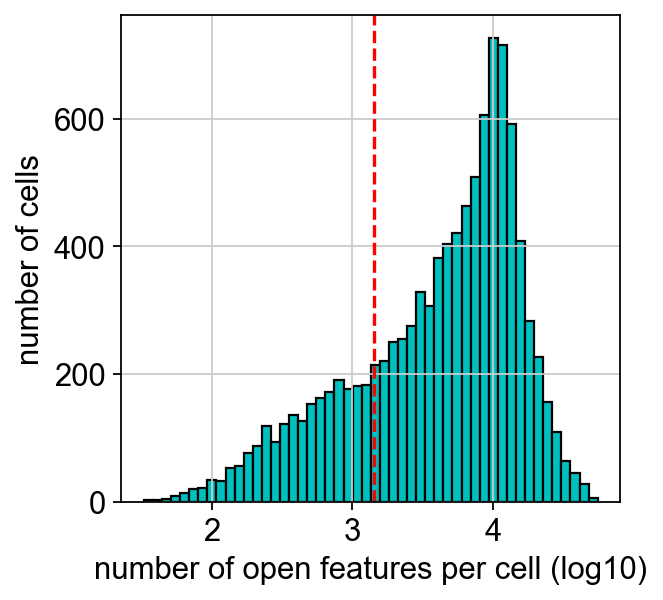

102


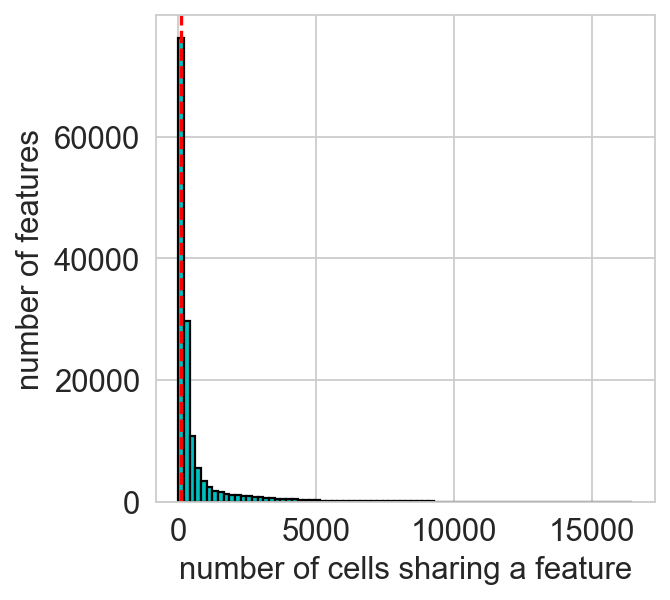

In [4]:
sc.settings.set_figure_params(figsize=('4', '4'), color_map='gist_earth')

min_cells = int(ref.shape[0] * 0.01)
min_features = int(ref.shape[1] * 0.01)
print(min_features)
#epi.pp.coverage_cells(ref, binary=True, log=False, bins=50, threshold=min_features)
epi.pp.coverage_cells(ref, binary=True, log='log10', bins=50, threshold=min_features)
print(min_cells)
epi.pp.coverage_features(ref, binary=True, log=False, bins=50, threshold=min_cells)
#epi.pp.coverage_features(ref, binary=True, log='log10', bins=50, threshold=min_cells)

In [5]:
print(ref.shape)
epi.pp.filter_cells(ref, min_features=min_features)
epi.pp.filter_features(ref, min_cells=min_cells)
print(ref.shape)

(10216, 142873)
(7770, 100673)


1428


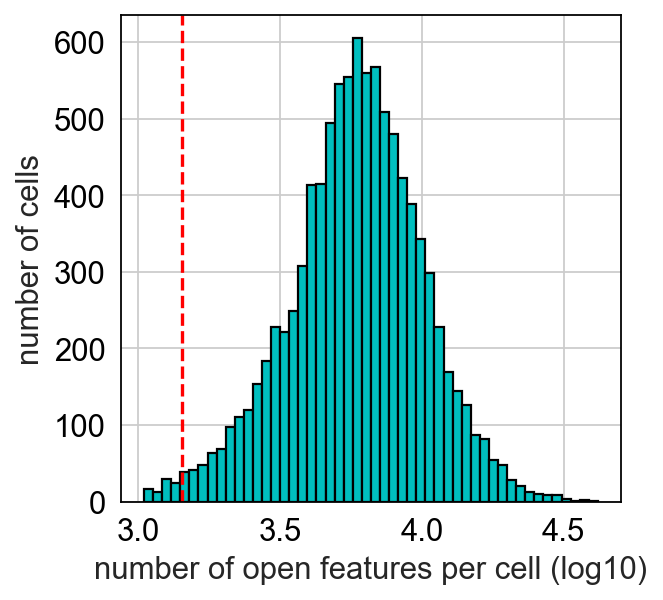

96


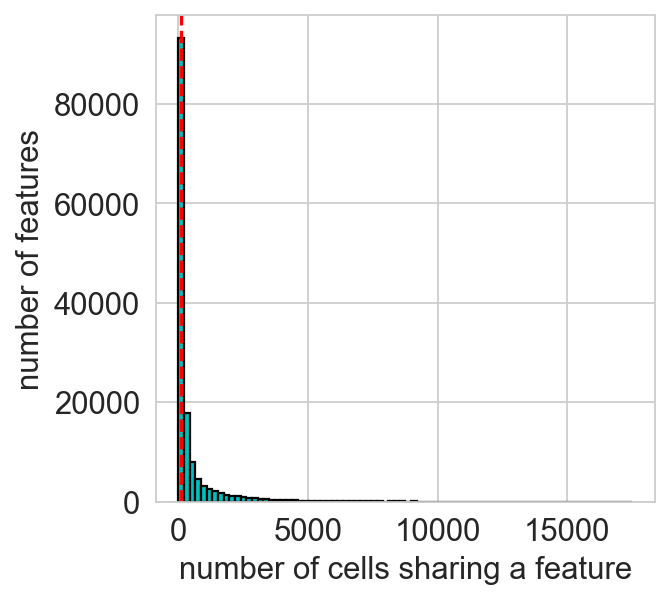

In [6]:
sc.settings.set_figure_params(figsize=('4', '4'), color_map='gist_earth')

min_cells = int(sample.shape[0] * 0.01)
min_features = int(sample.shape[1] * 0.01)
print(min_features)
epi.pp.coverage_cells(sample, binary=True, log='log10', bins=50, threshold=min_features)
print(min_cells)
epi.pp.coverage_features(sample, binary=True, log=False, bins=50, threshold=min_cells)

In [7]:
print(sample.shape)
epi.pp.filter_cells(sample, min_features=min_features)
epi.pp.filter_features(sample, min_cells=min_cells)
print(sample.shape)

(9642, 142873)
(9517, 76979)


In [ ]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')

sc.pp.normalize_total(sample)
epi.pp.log1p(sample)
#epi.pp.regress_out(sample, keys=["nCount_peaks"])
epi.pp.pca(sample, n_comps=50, svd_solver='arpack')
epi.pp.neighbors(sample,  n_neighbors=15)
epi.tl.umap(sample, min_dist=0.2)

In [ ]:
epi.pl.umap(sample, color=["predicted.id", "nCount_peaks"], legend_loc = 'on data')
sample.write(f'sample_example.h5ad')

In [10]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')

sc.pp.normalize_total(ref)
epi.pp.log1p(ref)
#epi.pp.regress_out(sample, keys=["nCount_peaks"])
epi.pp.pca(ref, n_comps=50, svd_solver='arpack')
epi.pp.neighbors(ref,  n_neighbors=15)
epi.tl.umap(ref, min_dist=0.2)

... storing 'wknn_res.0.8' as categorical
... storing 'seurat_clusters' as categorical
... storing 'subcluster' as categorical
... storing 'sample' as categorical


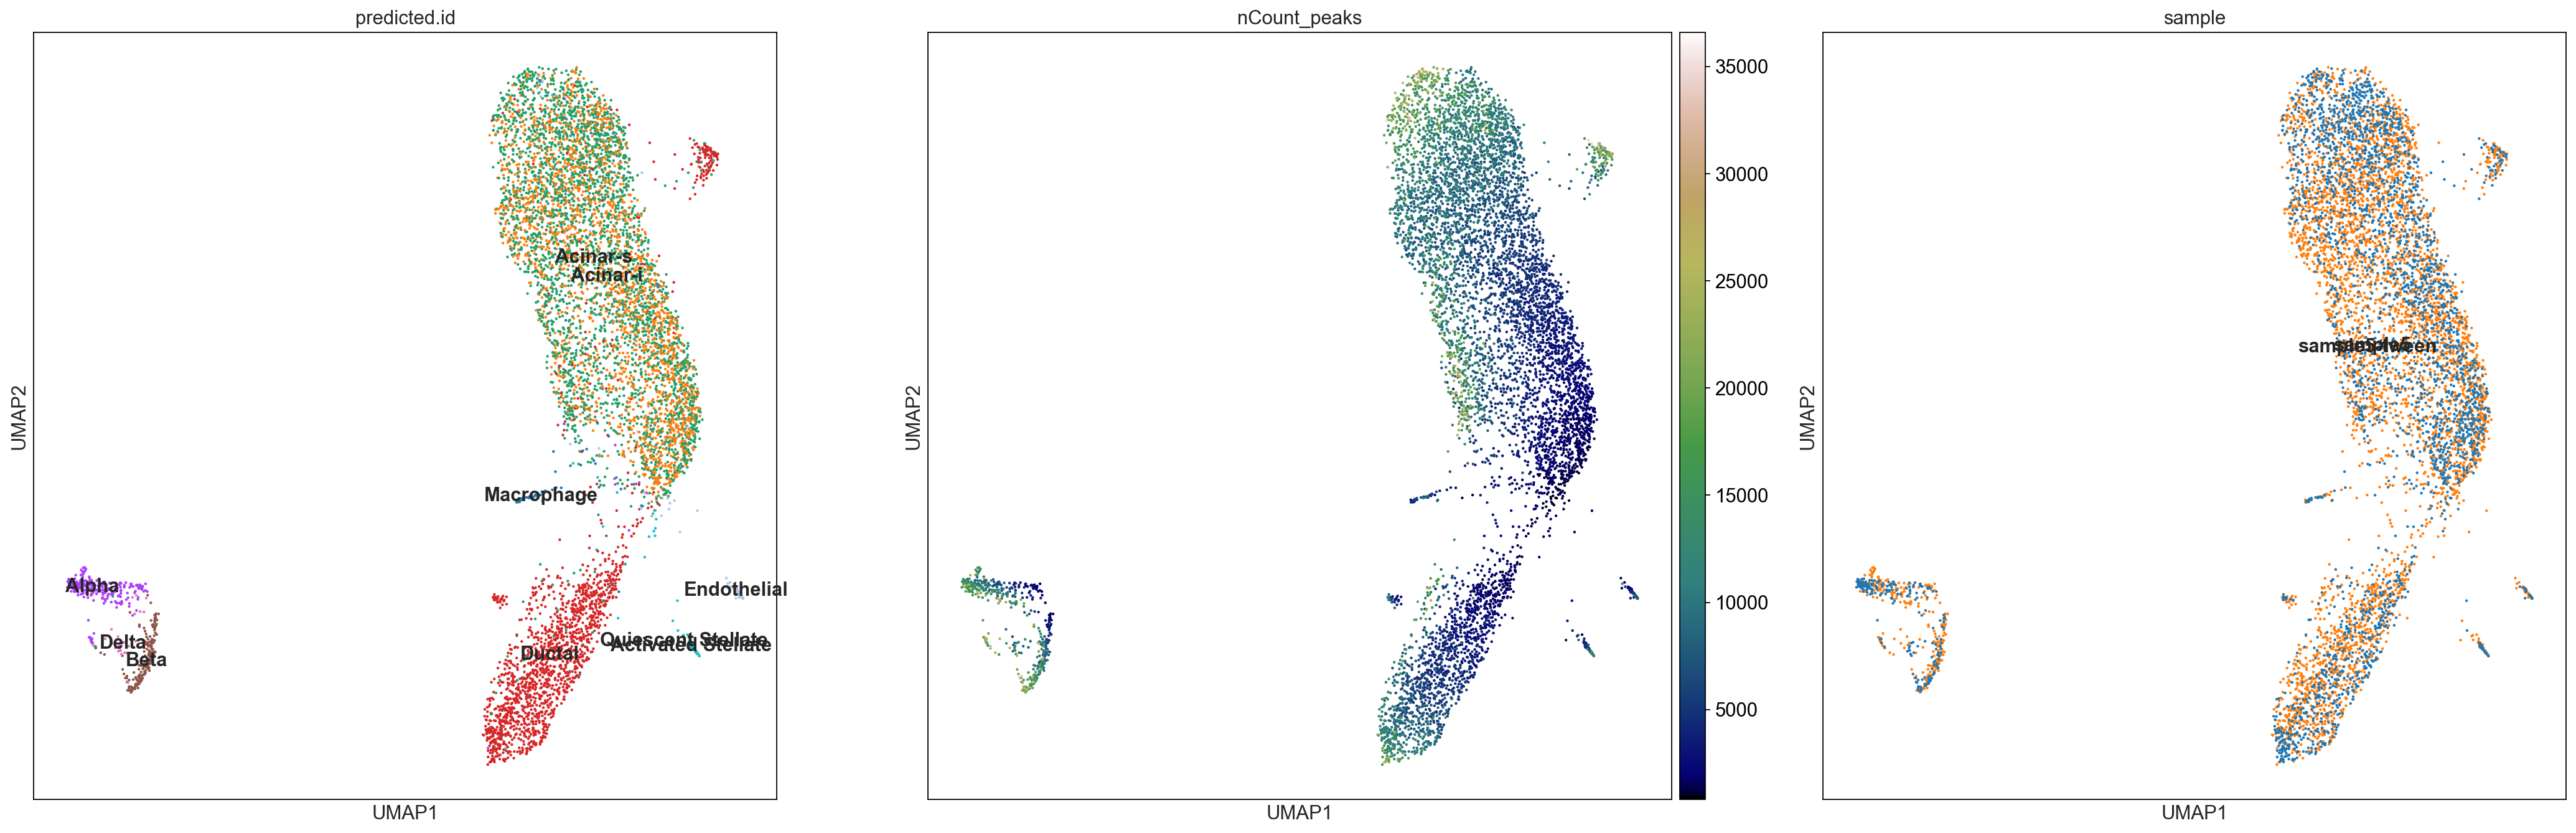

In [11]:
epi.pl.umap(ref, color=["predicted.id", "nCount_peaks", "sample"], legend_loc = 'on data')
ref.write(f'ref_example.h5ad')

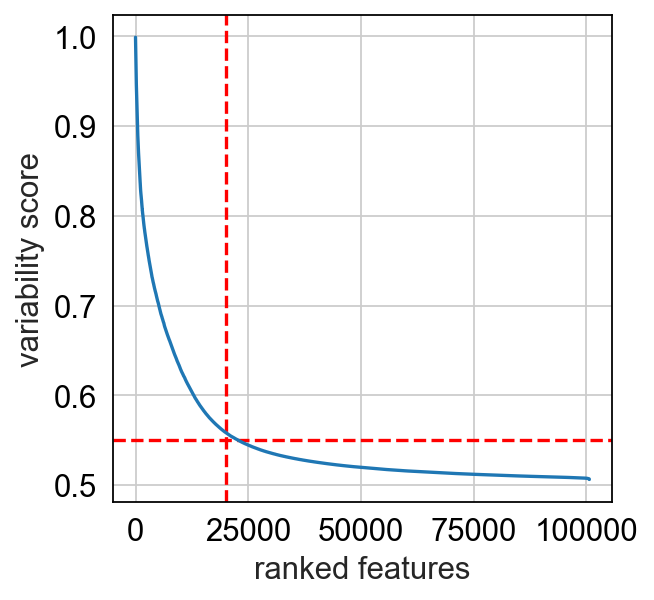

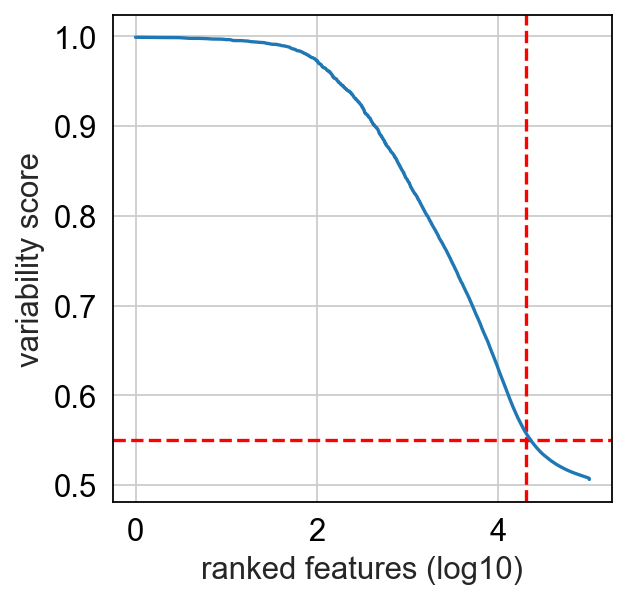

In [12]:
sc.settings.set_figure_params(figsize=('4', '4'), color_map='gist_earth')

min_score_value = 0.55
nb_feature_selected = 20000
epi.pl.variability_features(ref, log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(ref, log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

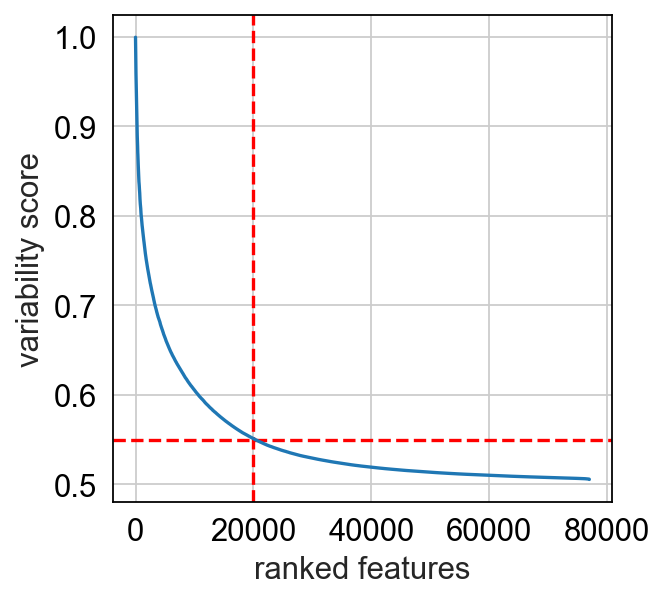

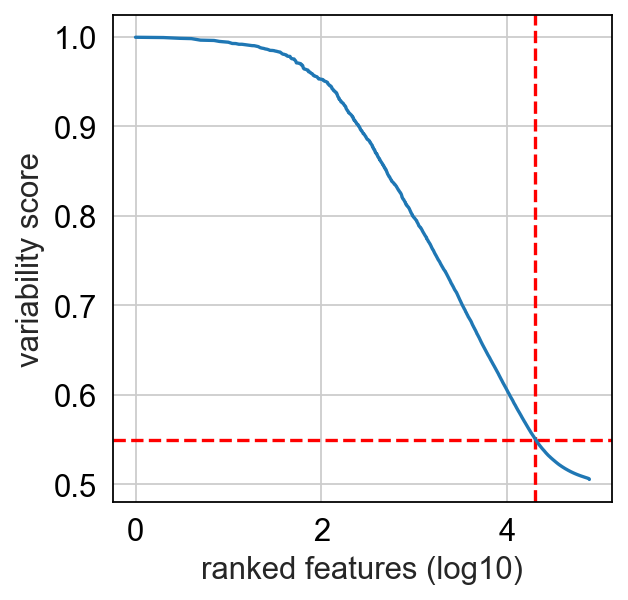

In [13]:
sc.settings.set_figure_params(figsize=('4', '4'), color_map='gist_earth')

min_score_value = 0.55
nb_feature_selected = 20000
epi.pl.variability_features(sample, log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(sample, log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

### Now load and process the reference we will use to annotate:

### Find common features between the two datasets and filter the others:

In [2]:
os.chdir("/home/pab/projects/ESPACE/ESPACE_multiome")
ref = sc.read_h5ad('ref_example.h5ad')
sample = sc.read_h5ad('sample_example.h5ad')

ref, sample = find_refmarkers_in_variable_peaks(ref, sample, target_n_peaks=5000)

Dimensions before filtering: (7770, 100673) and (9517, 76979)



Looking for 1111 marker features from each label
9999
Found 1578 peaks in common
Looking for 1211 marker features from each label
10899
Found 1859 peaks in common
Looking for 1311 marker features from each label
11799
Found 2164 peaks in common
Looking for 1411 marker features from each label
12699
Found 2457 peaks in common
Looking for 1511 marker features from each label
13599
Found 2743 peaks in common
Looking for 1611 marker features from each label
14499
Found 3044 peaks in common
Looking for 1711 marker features from each label
15399
Found 3398 peaks in common
Looking for 1811 marker features from each label
16299
Found 3714 peaks in common
Looking for 1911 marker features from each label
17199
Found 4053 peaks in common
Looking for 2011 marker features from each label
18099
Found 4442 peaks in common
Looking for 2111 marker features from each label
18999
Found 4812 peaks in common
Looking for 2211 marker features from each label
19899
Found 5180 peaks in common
Filtering the dat


Dimensions after filtering: (7761, 5180) and (9517, 5180)


### Prepare the reference data and train model:

In [3]:
!rm -r logs/*
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

n_feat = ref.shape[1]
n_labs = len(ref.obs['predicted.id'].cat.categories)
ds = DeepScore(hidden_nodes=[256, 124, 64], n_features=n_feat, 
               n_labels=n_labs, batch_size=64, dropout_rate=0.5, 
               epochs=30, weight_reg=True, l1=0.001, l2=0.001)

ds.set_reference(ref, label_by='predicted.id', test_prop=0.2)
ds.train(earlystopping=False, lr_scheduler=scheduler)
ds.model.save('atac_test_pancreas')

rm: cannot remove 'logs/*': No such file or directory


2021-10-28 16:40:04.782012: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-28 16:40:04.782102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kino
2021-10-28 16:40:04.782121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kino
2021-10-28 16:40:04.782321: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2021-10-28 16:40:04.782390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.91.3
2021-10-28 16:40:04.782407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.91.3
2021-10-28 16:40:04.783063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations

Model: "deepscore"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 5180)              20720     
_________________________________________________________________
dense256 (Dense)             (None, 256)               1326336   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense124 (Dense)             (None, 124)               31868     
_________________________________________________________________
dropout_1 (Dropout)          (None, 124)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 124)               49

2021-10-28 16:40:05.047524: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
11/88 [==>...........................] - ETA: 1s - loss: 27.4150 - categorical_accuracy: 0.1577

2021-10-28 16:40:06.124884: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-28 16:40:06.124904: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-28 16:40:06.139404: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-28 16:40:06.141291: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-28 16:40:06.144831: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2021_10_28_16_40_06

2021-10-28 16:40:06.146580: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./deepscore_logs/train/plugins/profile/2021_10_28_16_40_06/kino.trace.json.gz
2021-10-28 16:40:06.150332: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2021_10_28_16_40_06

2

88/88 [==============================] - 2s 16ms/step - loss: 21.6542 - categorical_accuracy: 0.3723 - val_loss: 15.0120 - val_categorical_accuracy: 0.6329
Epoch 2/30
88/88 [==============================] - 1s 13ms/step - loss: 11.5952 - categorical_accuracy: 0.6193 - val_loss: 9.2843 - val_categorical_accuracy: 0.6280
Epoch 3/30
88/88 [==============================] - 1s 13ms/step - loss: 8.5689 - categorical_accuracy: 0.6608 - val_loss: 7.8388 - val_categorical_accuracy: 0.6248
Epoch 4/30
88/88 [==============================] - 1s 13ms/step - loss: 7.4932 - categorical_accuracy: 0.6955 - val_loss: 7.3192 - val_categorical_accuracy: 0.6312
Epoch 5/30
88/88 [==============================] - 1s 13ms/step - loss: 6.8778 - categorical_accuracy: 0.7102 - val_loss: 6.7413 - val_categorical_accuracy: 0.6506
Epoch 6/30
88/88 [==============================] - 1s 14ms/step - loss: 6.4538 - categorical_accuracy: 0.7188 - val_loss: 6.3696 - val_categorical_accuracy: 0.6570
Epoch 7/30
88/88 [

2021-10-28 16:40:41.910878: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: atac_test_pancreas/assets


### Predict the celltypes in our sample using the trained model:

... storing 'Deepscore' as categorical


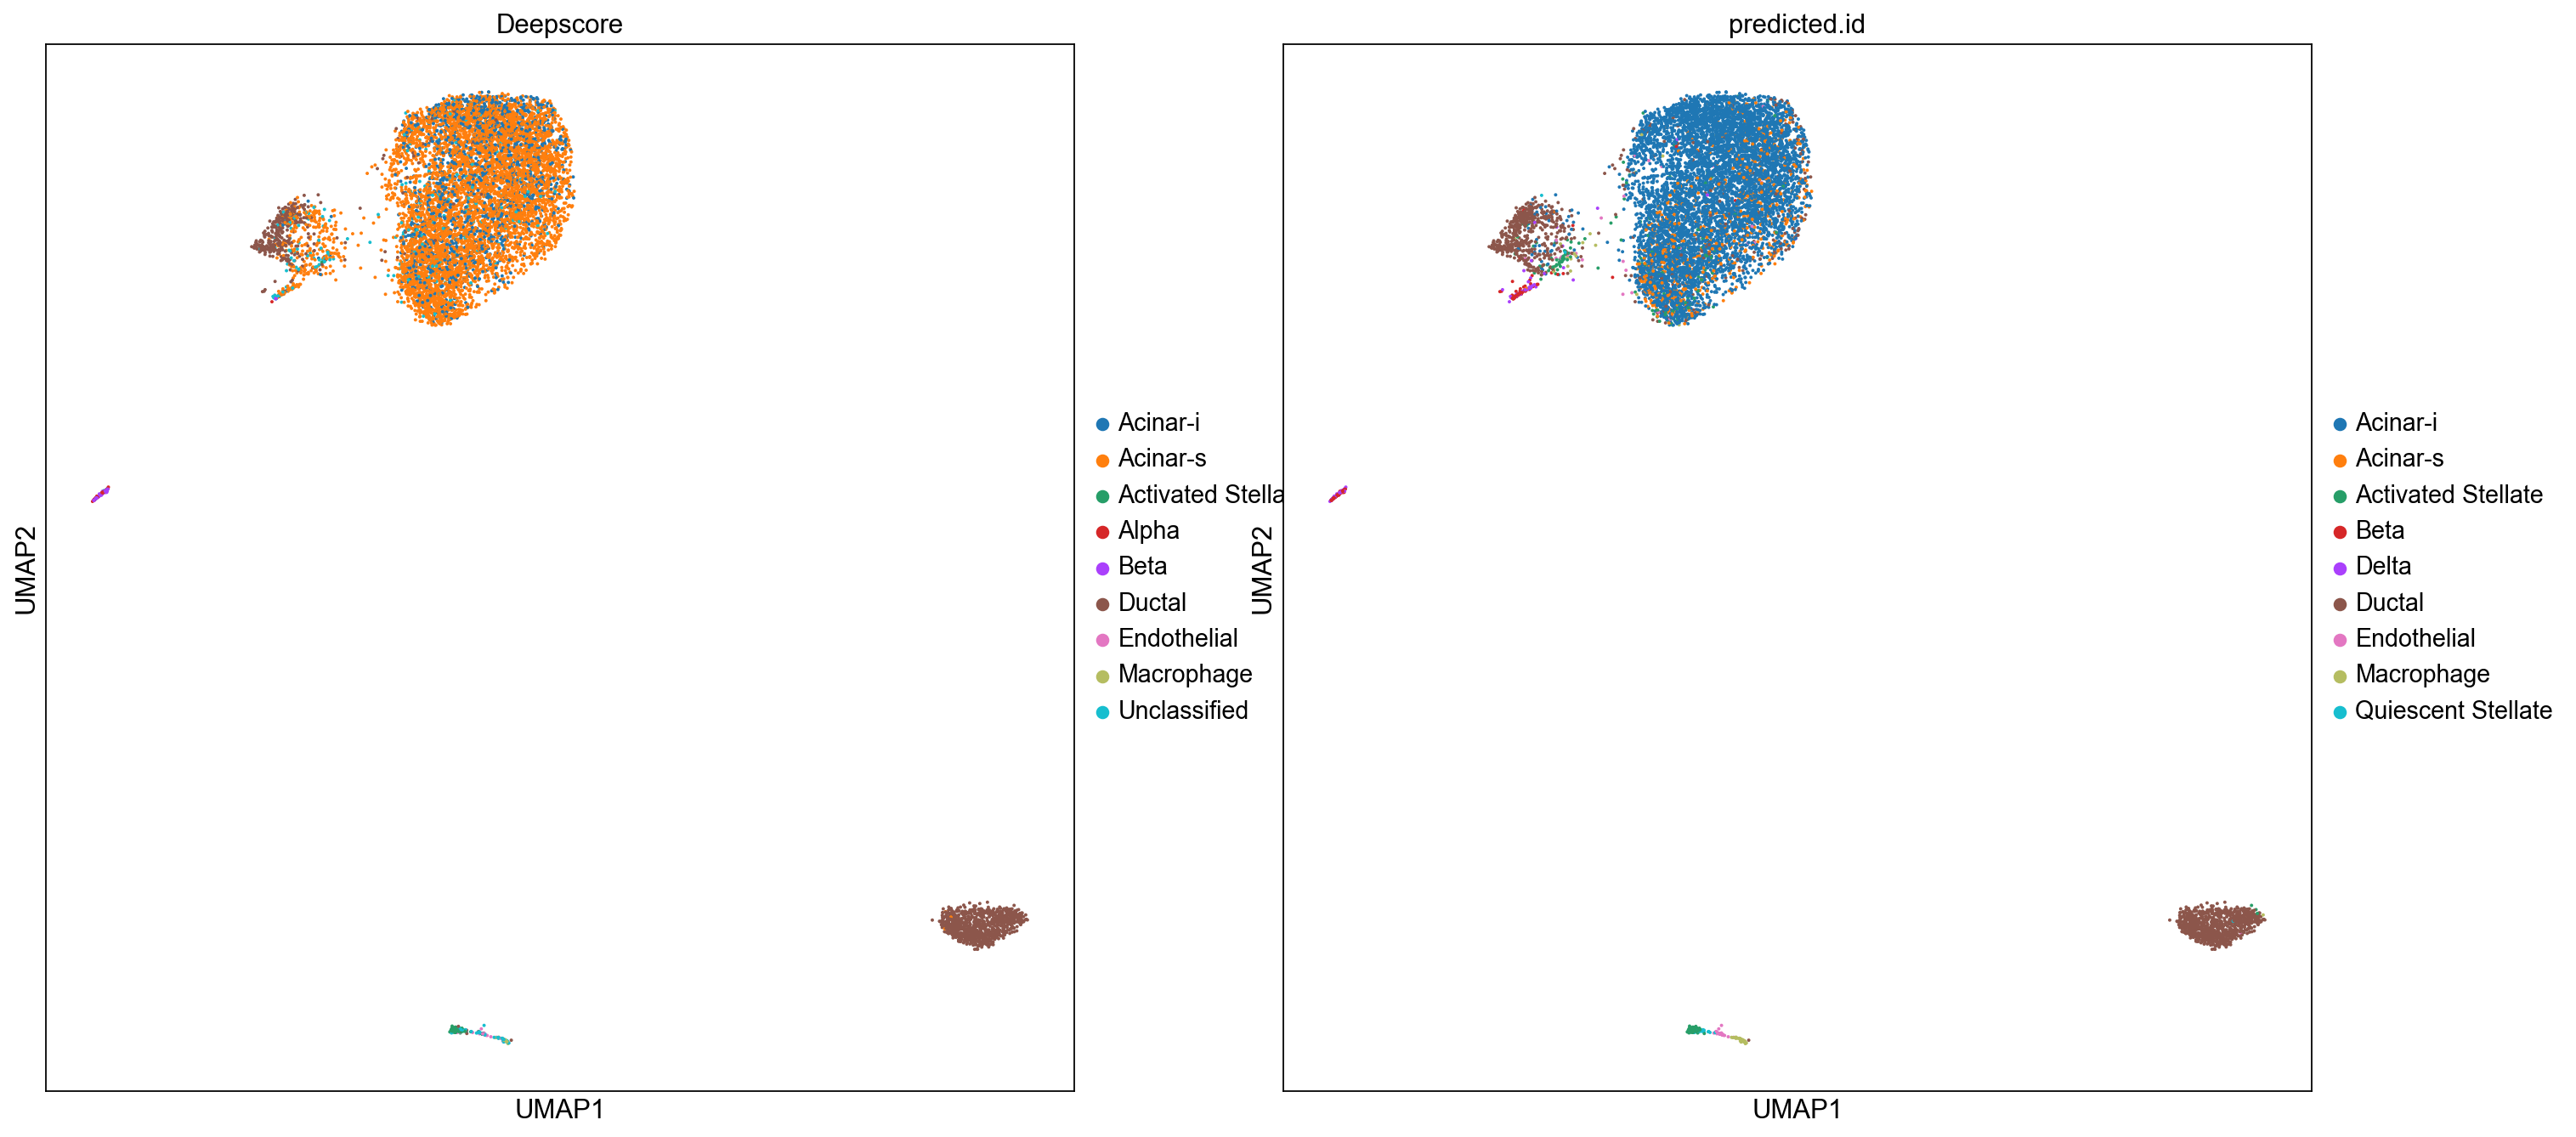

In [4]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')

sample = ds.annotate(sample)

sc.pl.umap(sample, color=['Deepscore', 'predicted.id'])

In [5]:
sample.obs['predicted.id'].value_counts()

Acinar-i              6569
Ductal                1689
Acinar-s               614
Activated Stellate     248
Beta                   131
Delta                  111
Macrophage              80
Endothelial             57
Quiescent Stellate      18
Name: predicted.id, dtype: int64

In [6]:
sample.obs['Deepscore'].value_counts()

Acinar-s              6069
Acinar-i              1538
Ductal                1350
Unclassified           294
Activated Stellate      84
Beta                    79
Alpha                   57
Macrophage              26
Endothelial             20
Name: Deepscore, dtype: int64

In [14]:
%tensorboard --logdir deepscore_logs

In [15]:
anno = sample.obs['Deepscore']
sample = sc.read_h5ad('sample_example.h5ad')
sample.obs['Deepscore'] = anno

sc.tl.rank_genes_groups(ref, 'predicted.id', method='wilcoxon')
sc.tl.rank_genes_groups(sample, 'Deepscore', method='wilcoxon')

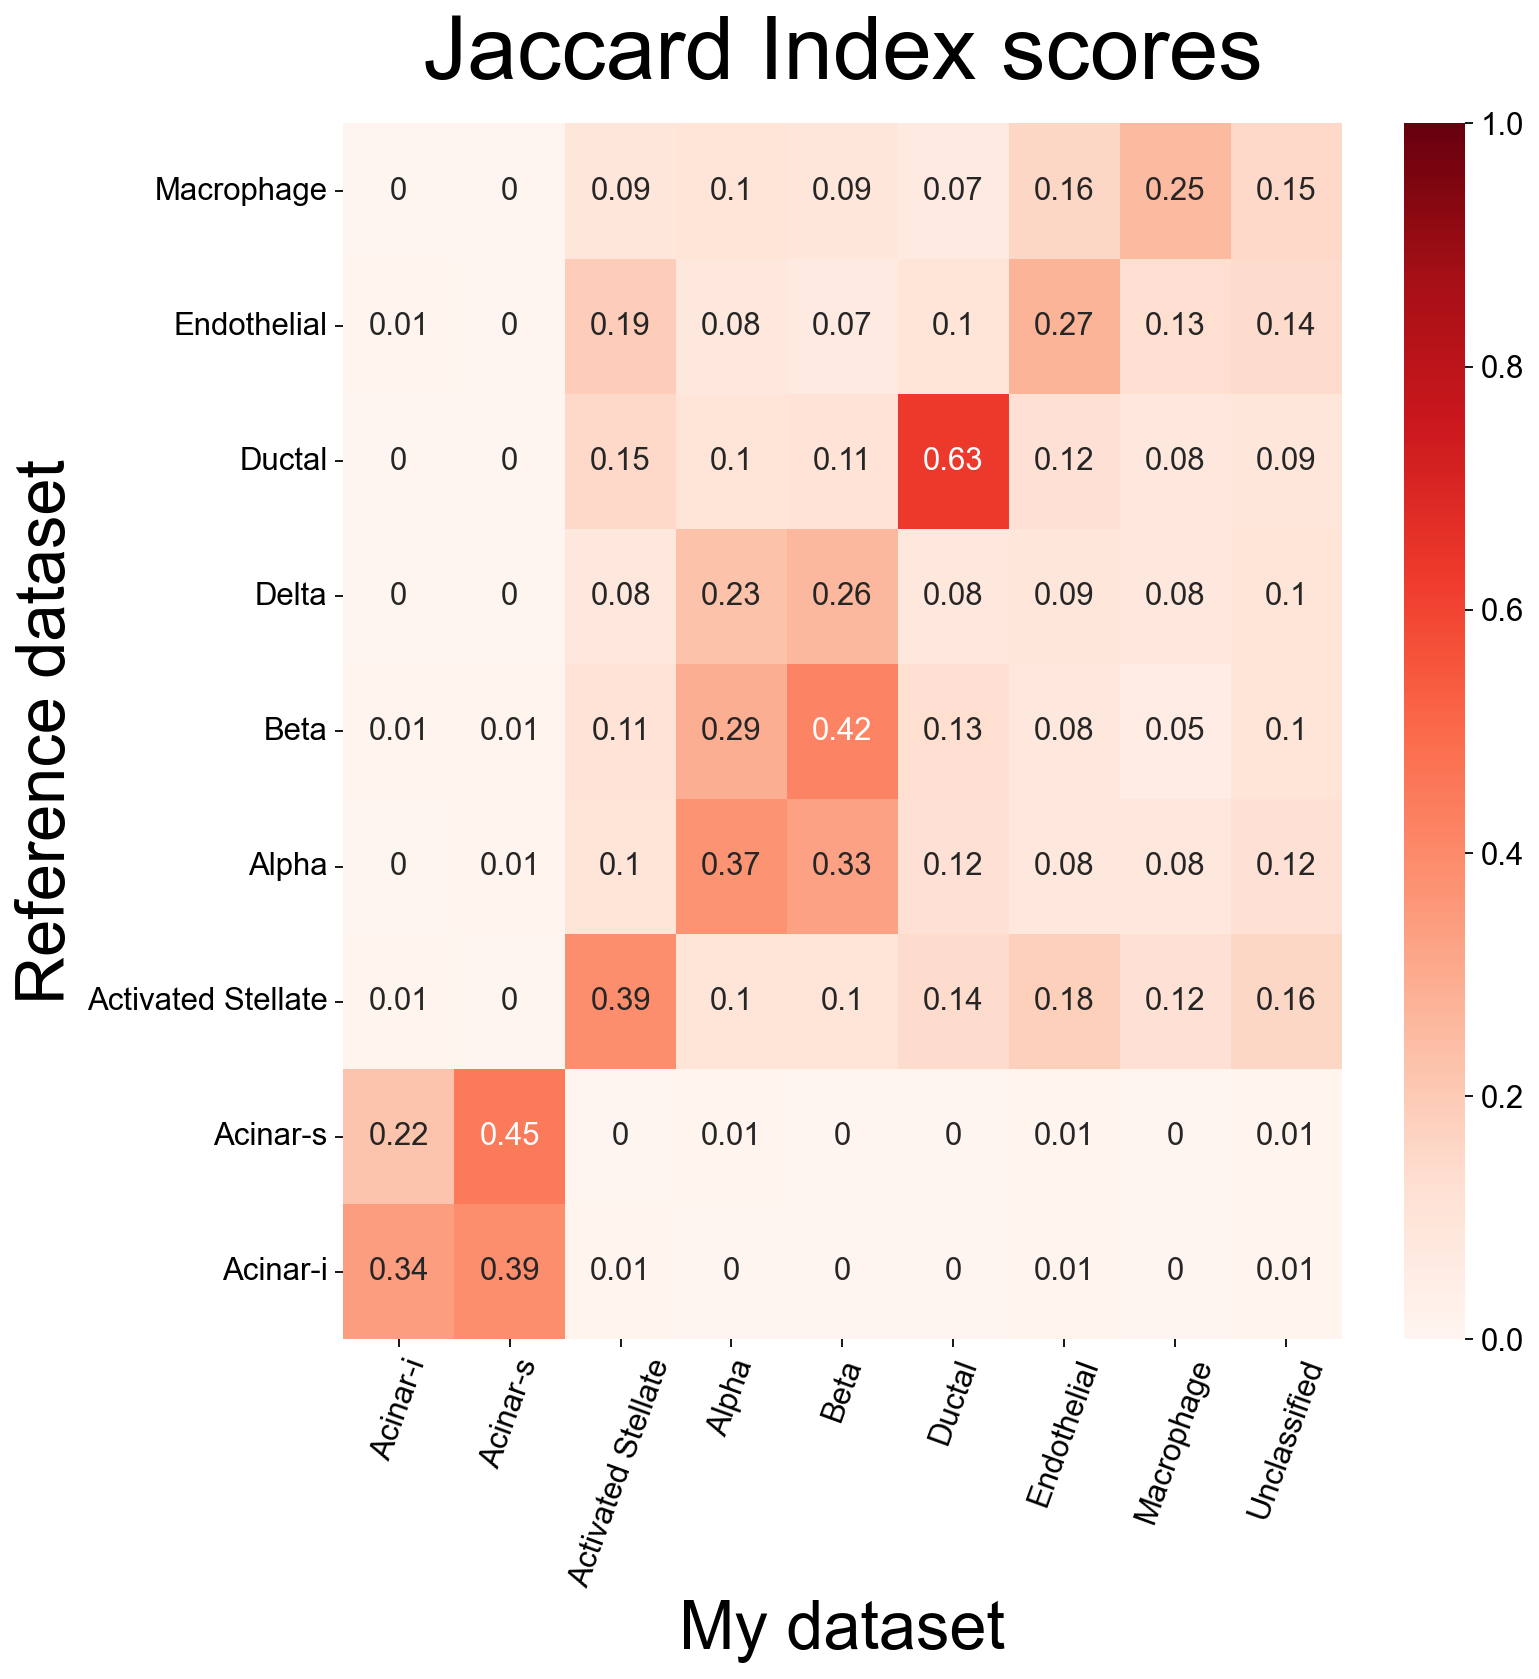

In [16]:
ref_markers = top_markers(ref, ntop=500)
sample_markers = top_markers(sample, ntop=500)
ref_markers.head(5), sample_markers.head(5)
ms = matchscore(ref_markers, sample_markers, plot=True)

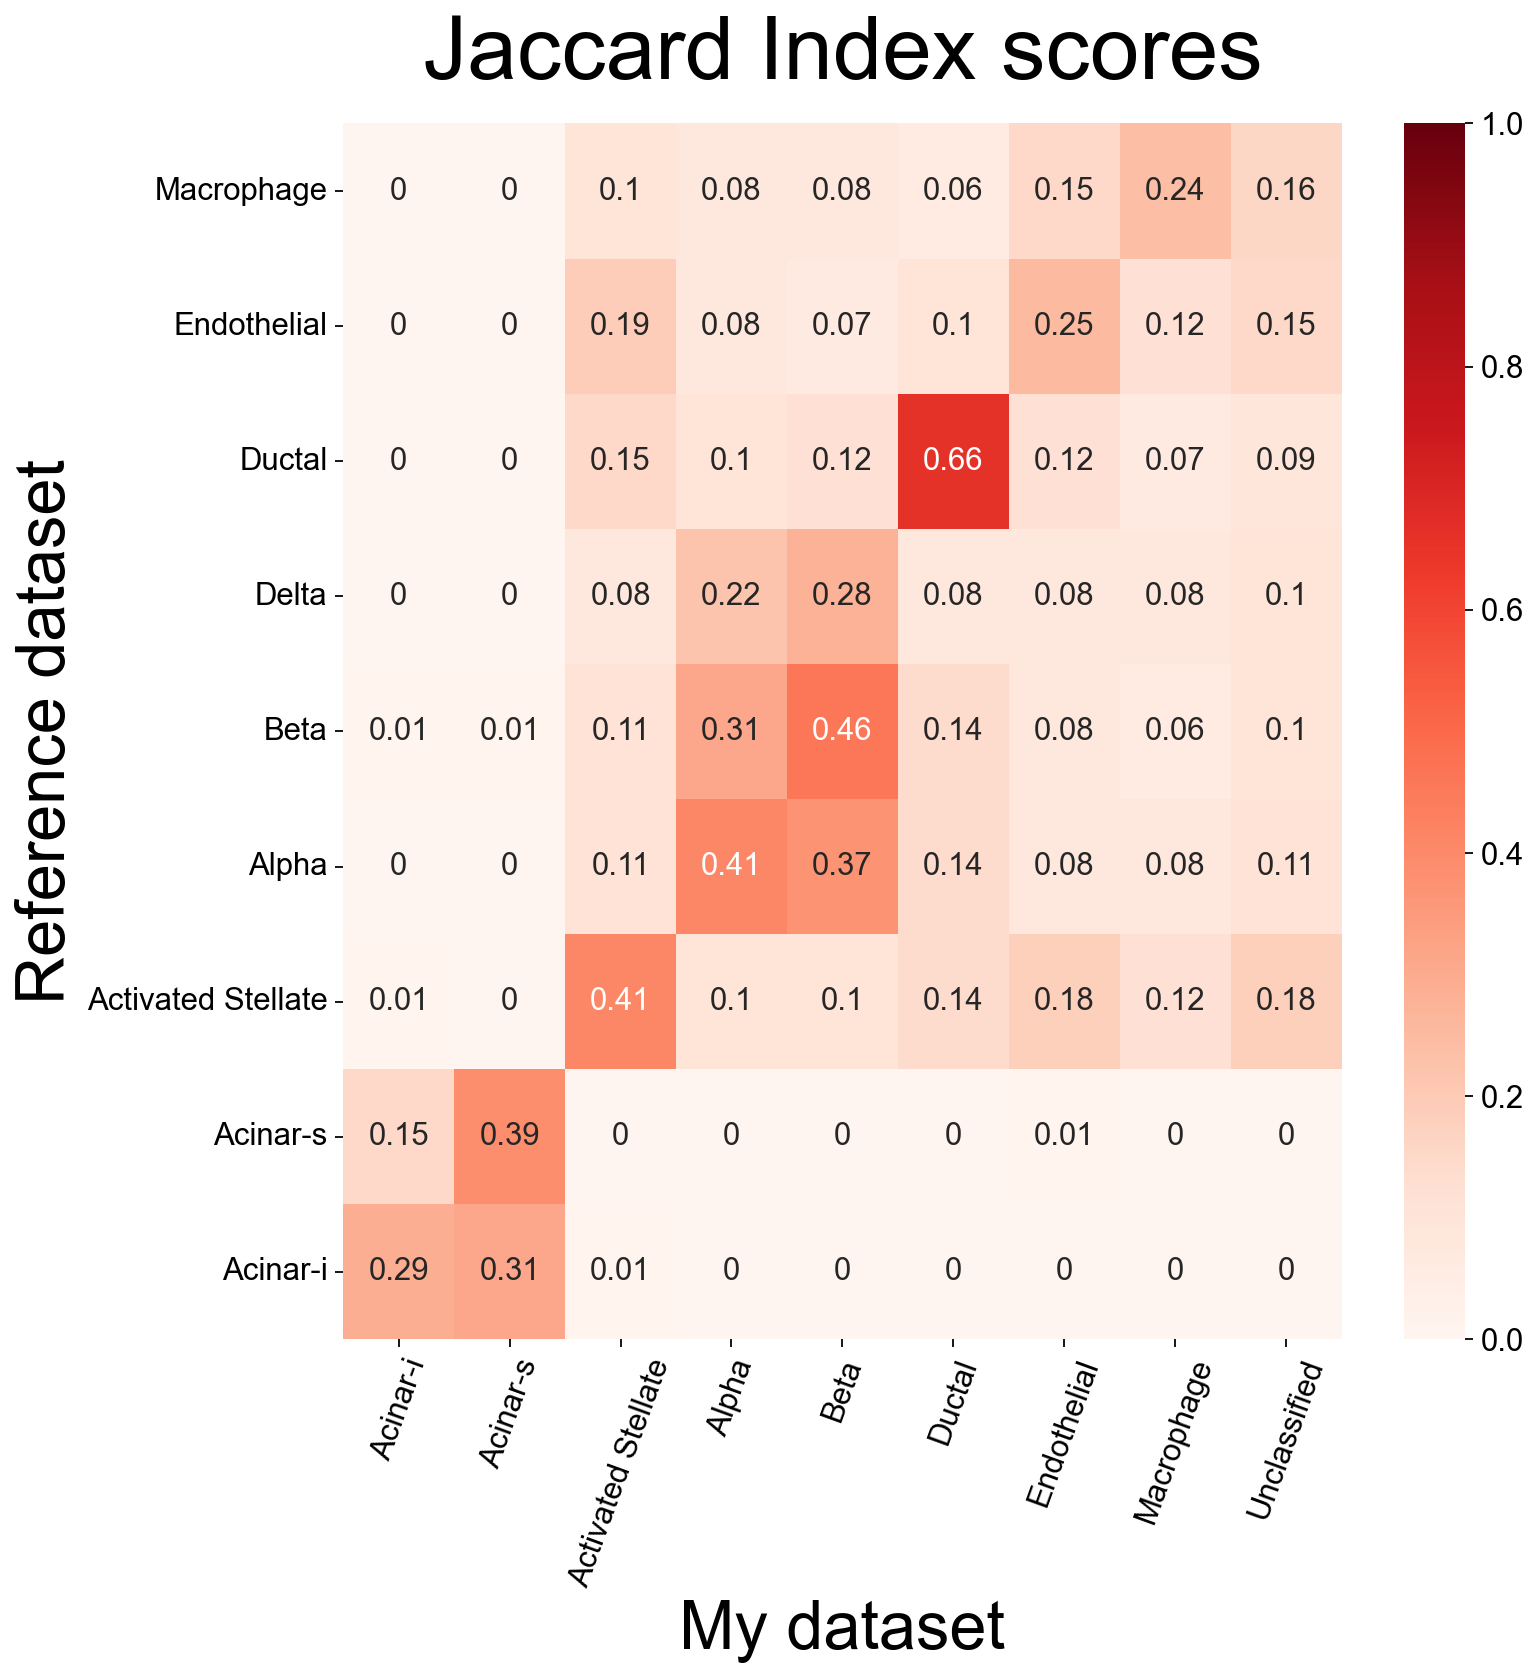

In [17]:
sc.tl.rank_genes_groups(ref, 'predicted.id', method='t-test')
sc.tl.rank_genes_groups(sample, 'Deepscore', method='t-test')
ref_markers2 = top_markers(ref, ntop=500)
sample_markers2 = top_markers(sample, ntop=500)
ms2 = matchscore(ref_markers2, sample_markers2, plot=True)

In [33]:
ref.uns['rank_features_groups']['names']
print(ref)

AnnData object with n_obs × n_vars = 7761 × 5180
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'wknn_res.0.8', 'seurat_clusters', 'subcluster', 'predicted.id', 'sample', 'nb_features'
    var: 'commonness', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'pca', 'predicted.id_colors', 'sample_colors', 'umap', 'log1p', 'rank_features_groups', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


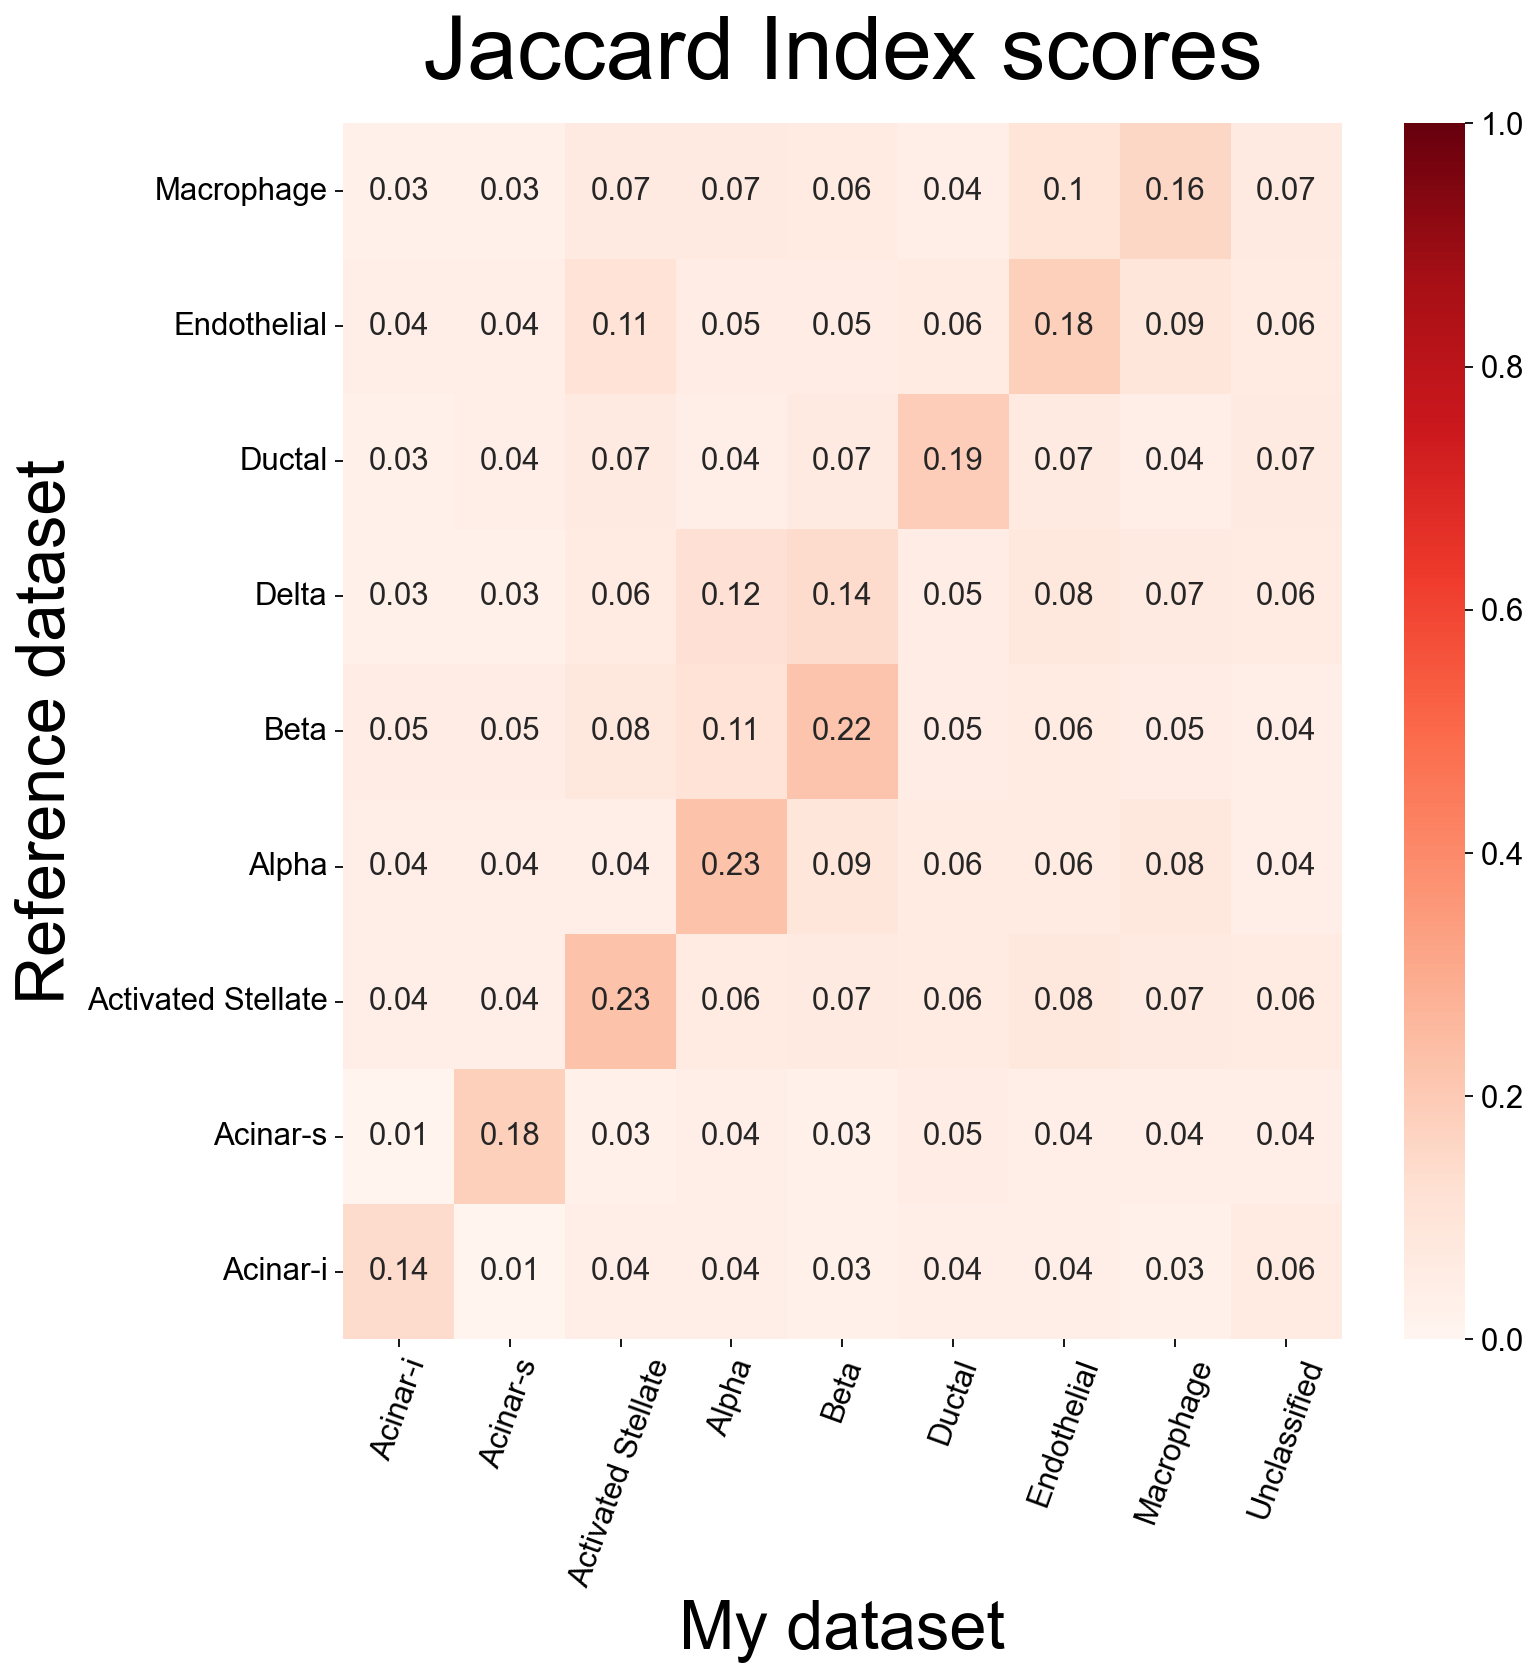

In [18]:
sc.tl.rank_genes_groups(ref, 'predicted.id', method='logreg', max_iter=500)
sc.tl.rank_genes_groups(sample, 'Deepscore', method='logreg', max_iter=500)
ref_markers3 = top_markers(ref, ntop=500)
sample_markers3 = top_markers(sample, ntop=500)
ms3 = matchscore(ref_markers3, sample_markers3, plot=True)

In [46]:
sample_markers = [item for sublist in sample_markers.values.tolist() for item in sublist]
sample_markers2 = [item for sublist in sample_markers2.values.tolist() for item in sublist]
sample_markers3 = [item for sublist in sample_markers3.values.tolist() for item in sublist]
ref_markers = [item for sublist in ref_markers.values.tolist() for item in sublist]
ref_markers2 = [item for sublist in ref_markers2.values.tolist() for item in sublist]
ref_markers3 = [item for sublist in ref_markers3.values.tolist() for item in sublist]

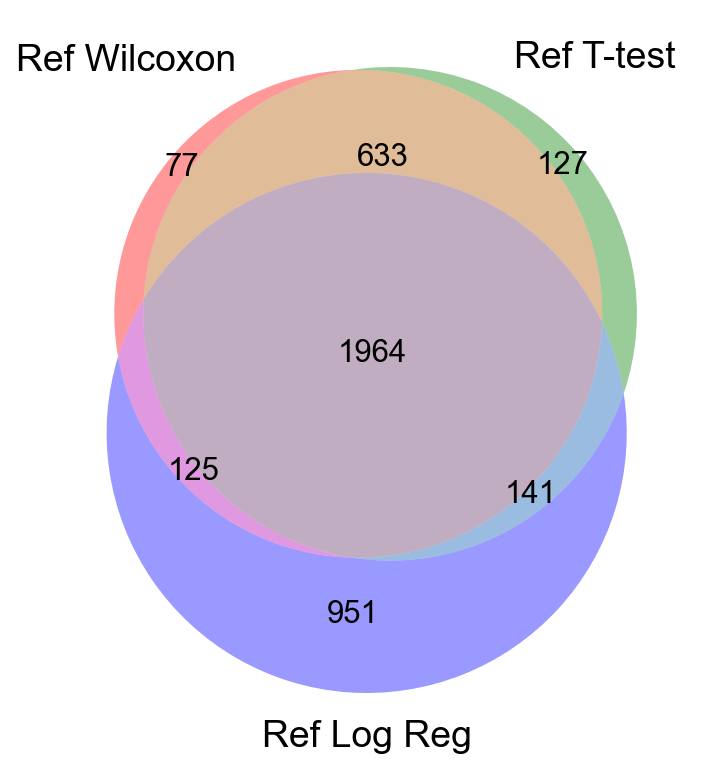

In [56]:
from matplotlib_venn import venn2, venn3
sc.settings.set_figure_params(figsize=('6', '6'), color_map='gist_earth')

venn3([set(ref_markers), set(ref_markers2), set(ref_markers3)], 
      set_labels = ['Ref Wilcoxon', 'Ref T-test', 'Ref Log Reg',
                   'Sample Wilcoxon', 'Sample T-test', 'Sample Log Reg'])
#plt.savefig('venn_diagram_markers.png')

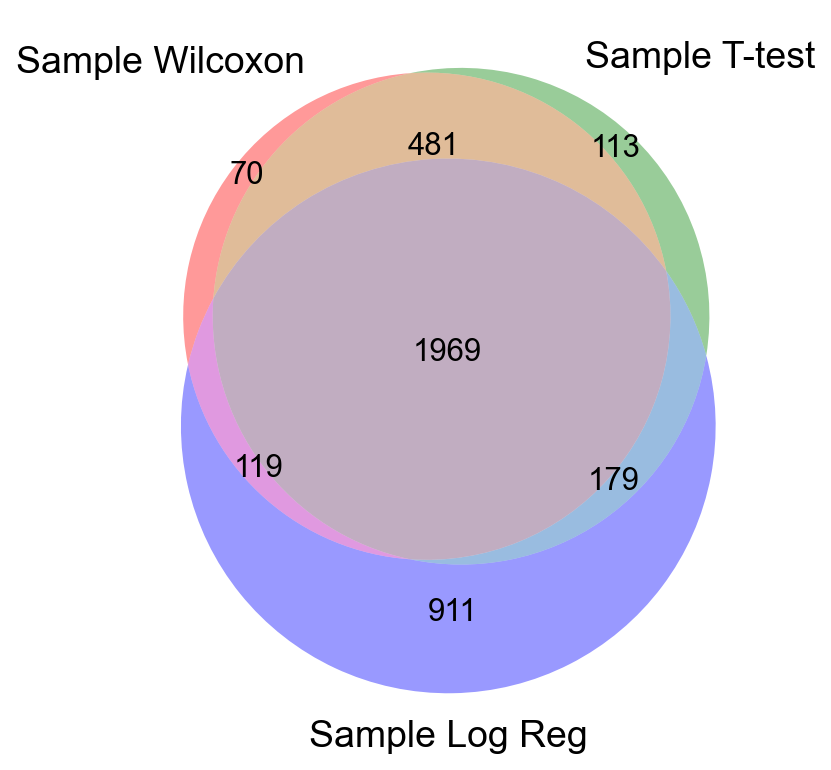

In [57]:
venn3([set(sample_markers), set(sample_markers2), set(sample_markers3)], 
      set_labels = ['Sample Wilcoxon', 'Sample T-test', 'Sample Log Reg'])

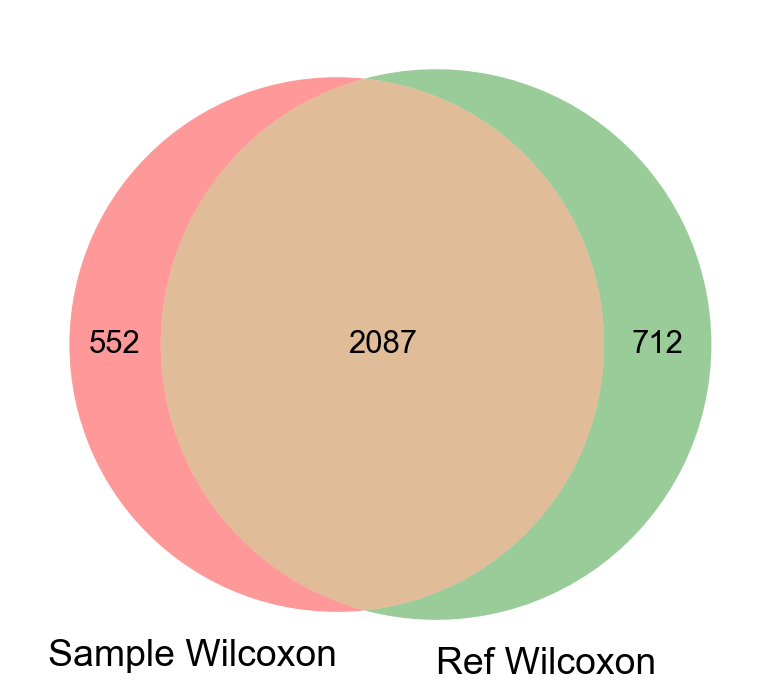

In [58]:
venn2([set(sample_markers), set(ref_markers)], set_labels = ['Sample Wilcoxon', 'Ref Wilcoxon'])

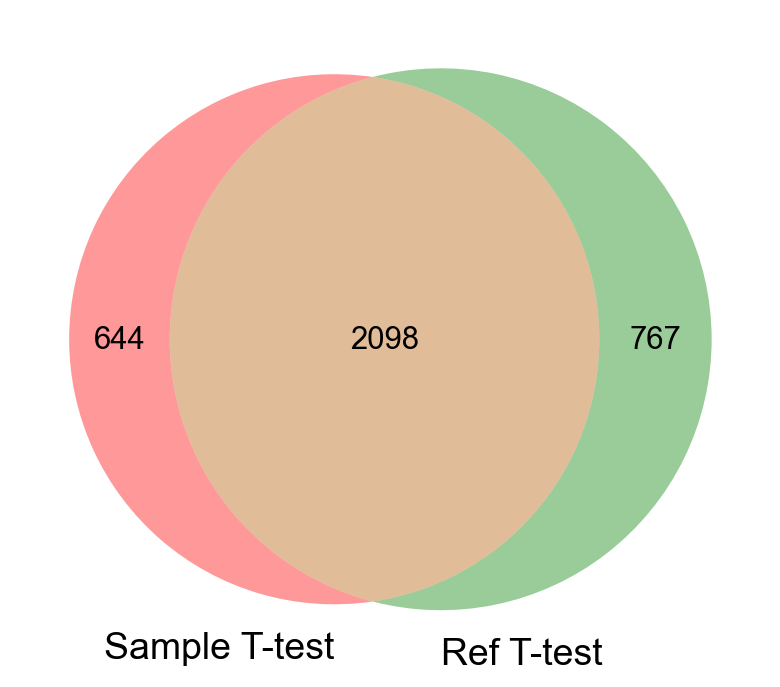

In [59]:
venn2([set(sample_markers2), set(ref_markers2)], set_labels = ['Sample T-test', 'Ref T-test'])

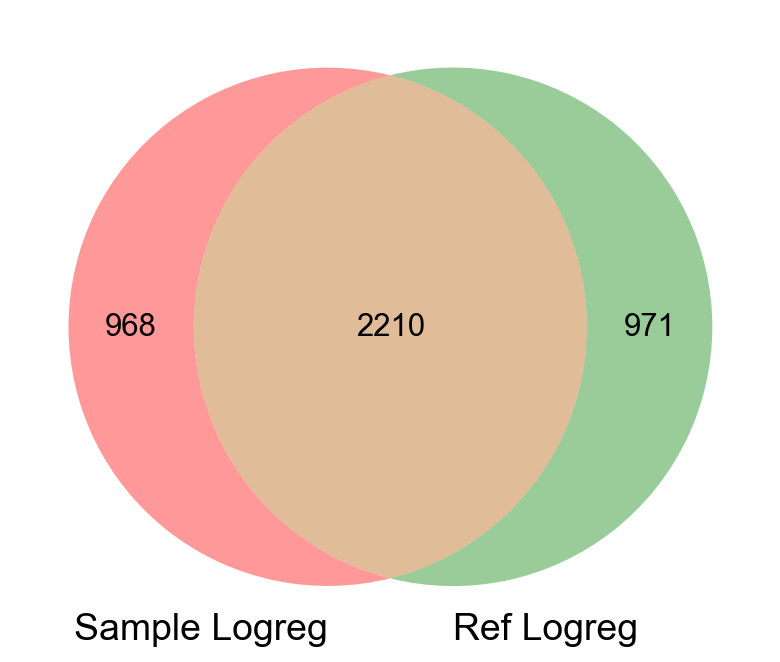

In [60]:
venn2([set(sample_markers3), set(ref_markers3)], set_labels = ['Sample Logreg', 'Ref Logreg'])

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

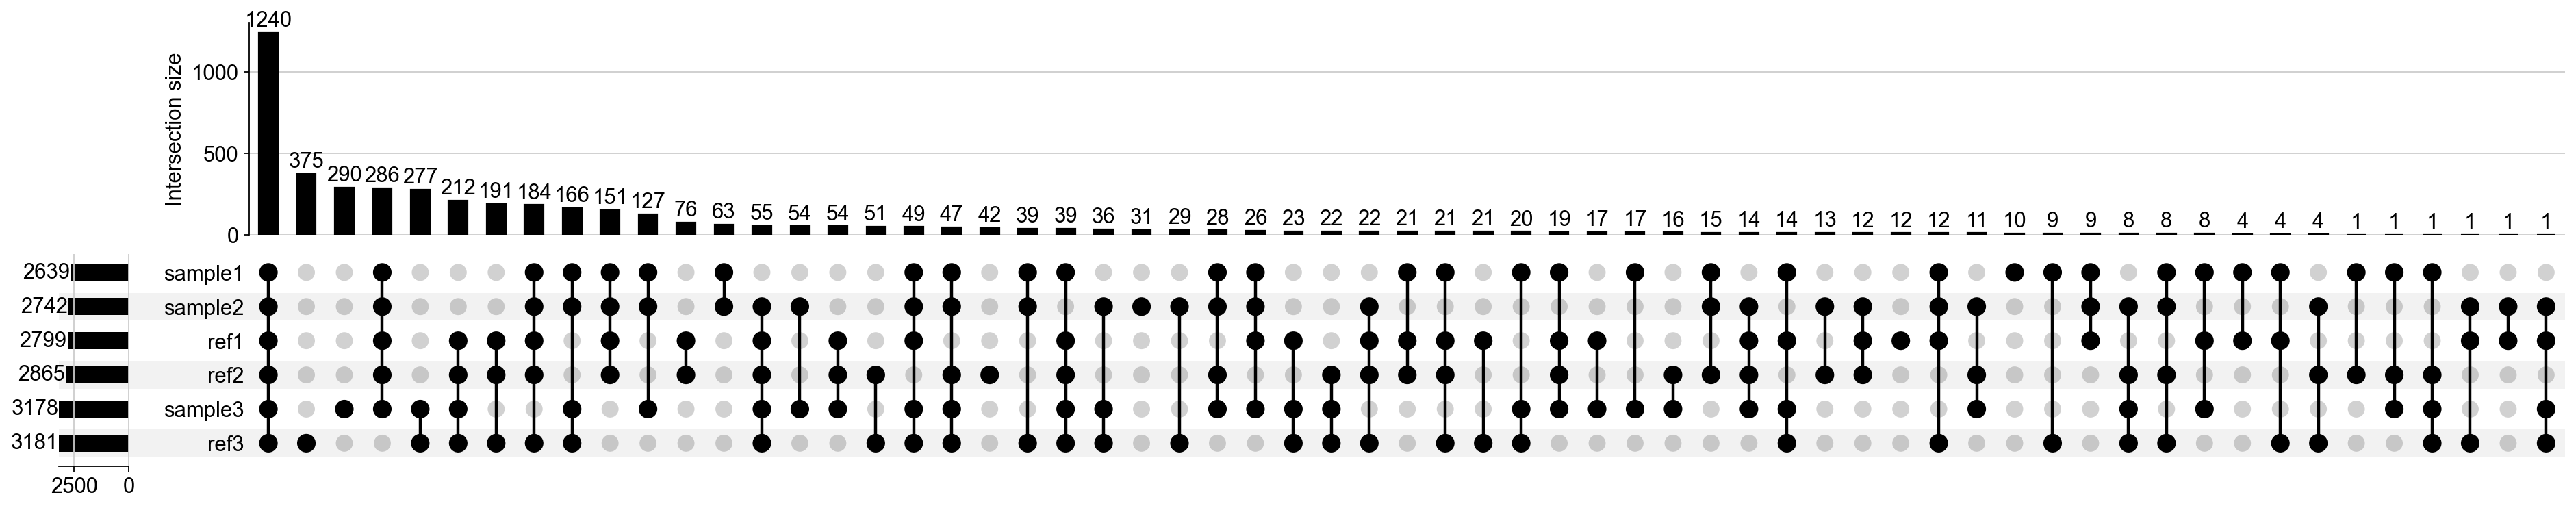

In [72]:
from upsetplot import from_contents, plot

dic = {'ref1':ref_markers, 'ref2':ref_markers2, 'ref3':ref_markers3, 
       'sample1':sample_markers, 'sample2':sample_markers2, 'sample3':sample_markers3}

for key in dic.keys():
    dic[key] = np.unique(dic[key])

toplot = from_contents(dic)
plot(toplot, show_counts='%d', sort_by='cardinality')